# CGM preediction tests #
## Michael Strand / Chelsea Huynh ##


In [586]:
import pandas as pd
import numpy as np
import matplotlib as plt

# breathing table

raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table

raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 

raw_glucose = pd.read_csv('P1_glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [587]:
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()


# take eta readings per minute rather than 60 (otherwise we have too many variables n > m)

eta = 3 # how many times per minute do we take a reading
raw_summary = raw_summary.iloc[::60//eta, :]

In [588]:
# normalize

qualities = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner')

def absolute_maximum_scale(series):
    return series / series.abs().max()

qualities_norm = qualities.copy()

for col in qualities.columns:
    if col != 'Time':
        qualities_norm[col] = absolute_maximum_scale(qualities[col])
        
qualities_norm = qualities_norm[['HR', 'ECGAmplitude', 'EcgWaveform']]
qualities = qualities[['HR', 'ECGAmplitude', 'EcgWaveform']]

Let each row of the new matrix A represent 5 minutes of observations. That is, each of the 3 experimental variables will appear 300 times and in tuples of (Hr, ECGAmplitude, EcgWaveform); grouped by exact seconds. These 3-tuples will be considered 'missing' if the average for the ECGNoise is large (i.e., > 0.005).

In [589]:
noise_copy = noise.copy()
qualities_copy = qualities.copy()
qualities_norm_copy = qualities_norm.copy()

# reshape data into A
feature_count = len(qualities.columns)

m = len(raw_glucose_day1_trim)
n = 5*eta*feature_count # where 5 is due to glucose measures being taken every 5 minutes

A = np.reshape(qualities_copy.to_numpy(), (m,n))
A_norm = np.reshape(qualities_norm_copy.to_numpy(), (m,n))

Below: each row represents 5 minutes worth of 1 second (HR, ECGamp, ECGwave) tuples) taken every 20 seconds

In [590]:
df_A = pd.DataFrame(A)
df_A_norm = pd.DataFrame(A_norm)

In [424]:
noise.describe()

,ECGNoise
count,37800.000000
mean,0.000348
std,0.000494
min,0.000020
25%,0.000080
50%,0.000160
75%,0.000400
max,0.009080


In [591]:
mask = np.ones((m,n))

noise_vec = noise_copy.to_numpy()
df_A_norm_copy = df_A_norm.copy().to_numpy()

too_high_noise = 0.0007800

index = 0
zeros = 0

for i in range(m):
    for j in range(n//feature_count):
        
        if noise_vec[index] > too_high_noise:
            
            zeros += 3
            df_A_norm_copy[i, 3*j:3*(j+1)] = 0
        
        index += 1

<AxesSubplot:>

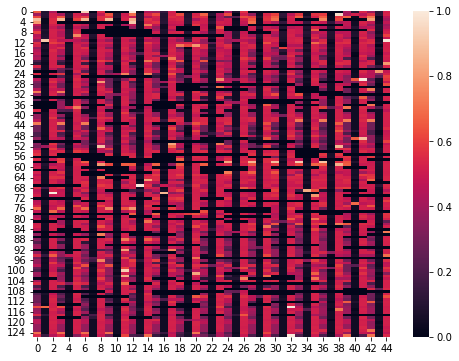

In [601]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_A_norm_copy, annot=False)

In [602]:
display(df_A_norm)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.662857,0.091743,0.427481,0.800000,0.012615,0.521190,0.931429,0.012615,0.546460,1.000000,...,0.524085,0.445714,0.108945,0.511977,0.411429,0.097477,0.531982,0.377143,0.104358,0.515925
1,0.400000,0.105505,0.518031,0.422857,0.107798,0.520400,0.445714,0.104358,0.485917,0.640000,...,0.568307,0.588571,0.004587,0.966833,0.422857,0.516055,0.453804,0.565714,0.111239,0.531192
2,0.611429,0.094037,0.520927,0.634286,0.103211,0.540142,0.582857,0.095183,0.555936,0.577143,...,0.525138,0.657143,0.028670,0.576467,0.668571,0.028670,0.545143,0.714286,0.026376,0.458542
3,0.885714,0.026376,0.547513,0.868571,0.026376,0.603580,0.857143,0.026376,0.561464,0.868571,...,0.524875,0.748571,0.030963,0.610950,0.765714,0.030963,0.474862,0.805714,0.030963,0.414056
4,0.794286,0.026376,0.553040,0.817143,0.026376,0.565938,0.874286,0.026376,0.513556,0.902857,...,0.520137,0.485714,0.126147,0.421163,0.480000,0.045872,0.529350,0.480000,0.045872,0.474862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.371429,0.045872,0.522243,0.371429,0.045872,0.519084,0.371429,0.045872,0.518821,0.371429,...,0.517505,0.371429,0.045872,0.519347,0.371429,0.045872,0.518558,0.371429,0.045872,0.519084
122,0.371429,0.045872,0.519874,0.371429,0.045872,0.522769,0.371429,0.045872,0.520137,0.371429,...,0.528034,0.371429,0.045872,0.528034,0.371429,0.045872,0.537510,0.382857,0.027523,0.499605
123,0.371429,0.045872,0.512503,0.371429,0.045872,0.517505,0.371429,0.045872,0.512767,0.371429,...,0.521716,0.542857,0.045872,0.518821,0.542857,0.045872,0.519874,0.702857,0.047018,0.515136
124,0.697143,0.045872,0.519874,0.697143,0.045872,0.524612,0.697143,0.045872,0.519610,0.697143,...,0.548039,0.382857,0.024083,0.514346,0.382857,0.045872,0.487233,0.457143,0.045872,0.479600


In [593]:
import random

# ell-tuples stochastic gradient descent algorithm 

# Parameters
    # n: number of columns
    # x: value to approximate (true soln of Ax = y)
    # maxiter: Iteration count stopping condition (this is our m, row count)
    # p: probability that Q-tuple will be blocked out
    # ell: size of missing tuples
    # alpha: Iteration step size

def ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        
        Ai_tilde = A_tilde[i,:]
        
        At = np.transpose(Ai_tilde)
        A1 = Ai_tilde*xhat - p*y[i]
        AA = np.dot(At, A1)
        AA = np.reshape(AA,(n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(Ai_tilde*xhat - y[i])**2
        resid_err[current_iter] = y_e
        
        current_iter += 1
            
    return resid_err

0.8507936507936508


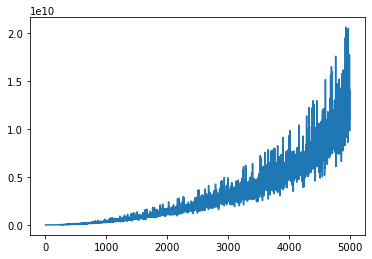

In [600]:
A_tilde = df_A_norm.to_numpy()

y_glucose = raw_glucose_day1_trim['glucose']


y = y_glucose.to_numpy()
maxiter = 5000
p = 1 - zeros/(m*n) # estimate for probability of too high noise
print(p)
ell = feature_count
alpha = 10**(-2)

lerr = ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha)

plt.plot(lerr)